In [1]:
!pip install sentencepiece scikit-learn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import sentencepiece as spm
import math
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# ===== 1. 경로 설정 =====
base_dir = os.path.expanduser("~/work/transformer_chatbot/data")
os.makedirs(base_dir, exist_ok=True)
csv_path = os.path.join(base_dir, "ChatbotData.csv")
train_txt = os.path.join(base_dir, "ChatbotData_clean.txt")
model_pref = os.path.join(base_dir, "spm_chatbot")

In [4]:
# ===== 2. 데이터 전처리 =====
df = pd.read_csv(csv_path)
print("원본 데이터 크기:", df.shape)

df = df.dropna(subset=['Q', 'A'])
df = df.drop_duplicates(subset=['Q', 'A'])

def clean_text(text):
    text = str(text)
    text = re.sub(r"[^가-힣0-9ㄱ-ㅎㅏ-ㅣ .,!?~]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"(ㅋ){2,}", "ㅋㅋ", text)
    text = re.sub(r"(ㅎ){2,}", "ㅎㅎ", text)
    return text

df['Q'] = df['Q'].apply(clean_text)
df['A'] = df['A'].apply(clean_text)
print("전처리 후 데이터 크기:", df.shape)

# txt 파일 저장
with open(train_txt, "w", encoding="utf-8") as f:
    for q, a in zip(df['Q'], df['A']):
        f.write(q + "\n")
        f.write(a + "\n")

원본 데이터 크기: (11823, 3)
전처리 후 데이터 크기: (11750, 3)


In [5]:
# ===== 3. SentencePiece 학습 (특수 토큰 포함) =====
spm.SentencePieceTrainer.Train(
    f"--input={train_txt} "
    f"--model_prefix={model_pref} "
    f"--vocab_size=8000 "
    f"--character_coverage=0.9995 "
    f"--model_type=bpe "
    f"--user_defined_symbols=<BOS>,<EOS>,<PAD> "
    f"--pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3"
)

# 토크나이저 로드
sp = spm.SentencePieceProcessor()
sp.load(f"{model_pref}.model")

# 특수 토큰 ID
PAD_ID = sp.piece_to_id('<PAD>')
BOS_ID = sp.piece_to_id('<BOS>')
EOS_ID = sp.piece_to_id('<EOS>')
UNK_ID = sp.piece_to_id('<UNK>')
vocab_size = sp.get_piece_size()

print(f"PAD_ID: {PAD_ID}, BOS_ID: {BOS_ID}, EOS_ID: {EOS_ID}, vocab_size: {vocab_size}")


PAD_ID: 6, BOS_ID: 4, EOS_ID: 5, vocab_size: 8000


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/home/jovyan/work/transformer_chatbot/data/ChatbotData_clean.txt --model_prefix=/home/jovyan/work/transformer_chatbot/data/spm_chatbot --vocab_size=8000 --character_coverage=0.9995 --model_type=bpe --user_defined_symbols=<BOS>,<EOS>,<PAD> --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/jovyan/work/transformer_chatbot/data/ChatbotData_clean.txt
  input_format: 
  model_prefix: /home/jovyan/work/transformer_chatbot/data/spm_chatbot
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokeniz

In [6]:
# ===== 4. 데이터셋 클래스 =====
class ChatbotDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=64):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        question = row['Q']
        answer = row['A']
        
        # 토큰화
        enc_input = self.tokenizer.encode_as_ids(question)
        dec_input = [BOS_ID] + self.tokenizer.encode_as_ids(answer)
        dec_target = self.tokenizer.encode_as_ids(answer) + [EOS_ID]
        
        # 패딩
        enc_input = self.pad_sequence(enc_input, self.max_length)
        dec_input = self.pad_sequence(dec_input, self.max_length)
        dec_target = self.pad_sequence(dec_target, self.max_length)
        
        return {
            'encoder_input': torch.tensor(enc_input, dtype=torch.long),
            'decoder_input': torch.tensor(dec_input, dtype=torch.long), 
            'decoder_target': torch.tensor(dec_target, dtype=torch.long)
        }
    
    def pad_sequence(self, seq, max_len):
        if len(seq) > max_len:
            return seq[:max_len]
        else:
            return seq + [PAD_ID] * (max_len - len(seq))

In [7]:
# ===== 5. 트랜스포머 모델 구현 =====

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=512):
        super().__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)  
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)
        
        output = self.W_o(attn_output)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model) 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, self_attn_mask, cross_attn_mask):
        attn_output = self.self_attn(x, x, x, self_attn_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, cross_attn_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) 
                                   for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout)
                                   for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, self_attn_mask, cross_attn_mask):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, enc_output, self_attn_mask, cross_attn_mask)
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super().__init__()
        self.encoder = Encoder(vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
        self.decoder = Decoder(vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
        self.linear = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def generate_mask(self, src, tgt):
        src_mask = (src != PAD_ID).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != PAD_ID).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask.to(tgt_mask.device)
        return src_mask, tgt_mask
    
    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, tgt_mask, src_mask)
        output = self.linear(dec_output)
        return output

In [8]:
# ===== 6. 데이터 로더 준비 =====
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_dataset = ChatbotDataset(train_df, sp, max_length=64)
val_dataset = ChatbotDataset(val_df, sp, max_length=64)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"학습 데이터: {len(train_dataset)}개")
print(f"검증 데이터: {len(val_dataset)}개")

# ===== 7. 모델 초기화 =====
model = Transformer(
    vocab_size=vocab_size,
    d_model=256,
    num_heads=8, 
    num_layers=4,
    d_ff=512,
    max_seq_length=128,
    dropout=0.1
)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

학습 데이터: 10575개
검증 데이터: 1175개
Using device: cuda


In [11]:
# ===== 7. 모델 구성 및 학습 설정 =====
model = Transformer(
    vocab_size=vocab_size,
    d_model=256,
    num_heads=8, 
    num_layers=4,
    d_ff=512,
    max_seq_length=128,
    dropout=0.1
)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [13]:
# ===== 8. 학습 함수 =====
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        src = batch['encoder_input'].to(device)
        tgt_input = batch['decoder_input'].to(device)
        tgt_output = batch['decoder_target'].to(device)
        
        optimizer.zero_grad()
        output = model(src, tgt_input)
        
        output = output.view(-1, vocab_size)
        tgt_output = tgt_output.view(-1)
        
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            src = batch['encoder_input'].to(device)
            tgt_input = batch['decoder_input'].to(device)
            tgt_output = batch['decoder_target'].to(device)
            
            output = model(src, tgt_input)
            
            output = output.view(-1, vocab_size)
            tgt_output = tgt_output.view(-1)
            
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)


In [14]:
# ===== 9. 학습 실행 =====
num_epochs = 30

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f'chatbot_epoch_{epoch+1}.pt')

print("✅ 학습 완료!")

Epoch 1/30:
Train Loss: 6.1734, Val Loss: 5.7037
Epoch 2/30:
Train Loss: 5.5113, Val Loss: 5.4233
Epoch 3/30:
Train Loss: 5.1813, Val Loss: 5.2120
Epoch 4/30:
Train Loss: 4.8898, Val Loss: 5.0690
Epoch 5/30:
Train Loss: 4.6389, Val Loss: 4.9342
Epoch 6/30:
Train Loss: 4.3979, Val Loss: 4.8251
Epoch 7/30:
Train Loss: 4.1632, Val Loss: 4.7219
Epoch 8/30:
Train Loss: 3.9217, Val Loss: 4.6148
Epoch 9/30:
Train Loss: 3.6757, Val Loss: 4.5305
Epoch 10/30:
Train Loss: 3.4288, Val Loss: 4.4351
Epoch 11/30:
Train Loss: 3.1805, Val Loss: 4.3615
Epoch 12/30:
Train Loss: 2.9341, Val Loss: 4.2944
Epoch 13/30:
Train Loss: 2.6981, Val Loss: 4.2308
Epoch 14/30:
Train Loss: 2.4638, Val Loss: 4.1810
Epoch 15/30:
Train Loss: 2.2399, Val Loss: 4.1255
Epoch 16/30:
Train Loss: 2.0262, Val Loss: 4.0829
Epoch 17/30:
Train Loss: 1.8231, Val Loss: 4.0478
Epoch 18/30:
Train Loss: 1.6307, Val Loss: 4.0243
Epoch 19/30:
Train Loss: 1.4477, Val Loss: 4.0018
Epoch 20/30:
Train Loss: 1.2838, Val Loss: 3.9711
Epoch 21/

In [20]:
#####10 . 과적합 문제로 인한 파라미터 수정###

model = Transformer(
    vocab_size=vocab_size,
    d_model=128,        # 256 → 128로 감소
    num_heads=4,        # 8 → 4로 감소 
    num_layers=2,       # 4 → 2로 감소
    d_ff=256,          # 512 → 256으로 감소
    max_seq_length=128,
    dropout=0.3        # 0.1 → 0.3으로 증가
)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = optim.Adam(model.parameters(), lr=5e-5)  # 1e-4 → 5e-5로 감소
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Using device: cuda


SyntaxError: 'break' outside loop (115114326.py, line 34)

In [23]:
# =====11. 재학습 실행 =====
best_val_loss = float('inf')
patience = 5
patience_counter = 0

num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 훈련 모드
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        enc_input = batch['encoder_input'].to(device)
        dec_input = batch['decoder_input'].to(device)
        dec_target = batch['decoder_target'].to(device)
        
        output = model(enc_input, dec_input)
        loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 검증 모드
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            enc_input = batch['encoder_input'].to(device)
            dec_input = batch['decoder_input'].to(device)
            dec_target = batch['decoder_target'].to(device)
            
            output = model(enc_input, dec_input)
            loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
            
            total_val_loss += loss.item()
    
    # 평균 손실 계산
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early Stopping 체크 (여기가 반복문 안!)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("✓ 모델 저장됨")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break  # 이제 for 루프 안에 있어서 정상 작동

Epoch 1/30: Train Loss: 4.7541, Val Loss: 5.0244
✓ 모델 저장됨
Epoch 2/30: Train Loss: 4.7250, Val Loss: 5.0053
✓ 모델 저장됨
Epoch 3/30: Train Loss: 4.6916, Val Loss: 4.9911
✓ 모델 저장됨
Epoch 4/30: Train Loss: 4.6591, Val Loss: 4.9746
✓ 모델 저장됨
Epoch 5/30: Train Loss: 4.6250, Val Loss: 4.9544
✓ 모델 저장됨
Epoch 6/30: Train Loss: 4.5980, Val Loss: 4.9358
✓ 모델 저장됨
Epoch 7/30: Train Loss: 4.5632, Val Loss: 4.9182
✓ 모델 저장됨
Epoch 8/30: Train Loss: 4.5316, Val Loss: 4.9080
✓ 모델 저장됨
Epoch 9/30: Train Loss: 4.5027, Val Loss: 4.8875
✓ 모델 저장됨
Epoch 10/30: Train Loss: 4.4712, Val Loss: 4.8712
✓ 모델 저장됨
Epoch 11/30: Train Loss: 4.4444, Val Loss: 4.8601
✓ 모델 저장됨
Epoch 12/30: Train Loss: 4.4124, Val Loss: 4.8455
✓ 모델 저장됨
Epoch 13/30: Train Loss: 4.3815, Val Loss: 4.8295
✓ 모델 저장됨
Epoch 14/30: Train Loss: 4.3532, Val Loss: 4.8161
✓ 모델 저장됨
Epoch 15/30: Train Loss: 4.3259, Val Loss: 4.8051
✓ 모델 저장됨
Epoch 16/30: Train Loss: 4.2891, Val Loss: 4.7889
✓ 모델 저장됨
Epoch 17/30: Train Loss: 4.2621, Val Loss: 4.7779
✓ 모델 저장됨
Epoch 

In [24]:
# ===== 12. 추론 함수 =====
def generate_response(model, question, max_length=64):
    model.eval()
    with torch.no_grad():
        # 질문 토큰화
        src = sp.encode_as_ids(question)
        src = torch.tensor([src], dtype=torch.long).to(device)
        
        # 디코더 입력 초기화
        tgt = torch.tensor([[BOS_ID]], dtype=torch.long).to(device)
        
        for _ in range(max_length):
            output = model(src, tgt)
            next_token = output[:, -1, :].argmax(dim=-1).unsqueeze(1)
            
            if next_token.item() == EOS_ID:
                break
                
            tgt = torch.cat([tgt, next_token], dim=1)
        
        # 디코딩
        response_ids = tgt[0][1:].tolist()  # BOS 제거
        response = sp.decode_ids(response_ids)
        
    return response

# 테스트
test_questions = ["안녕하세요", "오늘 날씨 어때?", "뭐하고 있어?"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 안녕하세요
A: 좋은 친구를 두셨네요.

Q: 오늘 날씨 어때?
A: 직접 물어보세요.

Q: 뭐하고 있어?
A: 직접 물어보세요.



In [26]:
#===============13. 학습률  수정========
#생각보다 테스트 결과가 이상함
model = Transformer(
    vocab_size=vocab_size,
    d_model=128,        # 256 → 128로 감소
    num_heads=4,        # 8 → 4로 감소 
    num_layers=2,       # 4 → 2로 감소
    d_ff=256,          # 512 → 256으로 감소
    max_seq_length=128,
    dropout=0.3        # 0.1 → 0.3으로 증가
)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # 1e-4 재수정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [27]:
#============14. 재학습 에포크 증가(30->50)=============
best_val_loss = float('inf')
patience = 5
patience_counter = 0

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # ========== 훈련 모드 ==========
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        enc_input = batch['encoder_input'].to(device)
        dec_input = batch['decoder_input'].to(device)
        dec_target = batch['decoder_target'].to(device)
        
        output = model(enc_input, dec_input)
        loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # 훈련 정확도 계산
        predictions = output.view(-1, vocab_size).argmax(dim=-1)
        targets = dec_target.view(-1)
        
        # PAD 토큰 제외하고 정확도 계산
        mask = targets != PAD_ID
        train_correct += (predictions == targets)[mask].sum().item()
        train_total += mask.sum().item()
    
    # ========== 검증 모드 ==========
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            enc_input = batch['encoder_input'].to(device)
            dec_input = batch['decoder_input'].to(device)
            dec_target = batch['decoder_target'].to(device)
            
            output = model(enc_input, dec_input)
            loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
            
            total_val_loss += loss.item()
            
            # 검증 정확도 계산
            predictions = output.view(-1, vocab_size).argmax(dim=-1)
            targets = dec_target.view(-1)
            
            # PAD 토큰 제외하고 정확도 계산
            mask = targets != PAD_ID
            val_correct += (predictions == targets)[mask].sum().item()
            val_total += mask.sum().item()
    
    # ========== 평균 계산 ==========
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = train_correct / train_total if train_total > 0 else 0
    val_accuracy = val_correct / val_total if val_total > 0 else 0
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("  ✓ 모델 저장됨")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break
    
    print("-" * 50)

Epoch 1/50:
  Train Loss: 6.8630, Train Acc: 0.2695
  Val Loss: 6.0663, Val Acc: 0.2911
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 2/50:
  Train Loss: 5.9508, Train Acc: 0.2885
  Val Loss: 5.8520, Val Acc: 0.2952
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 3/50:
  Train Loss: 5.7895, Train Acc: 0.2910
  Val Loss: 5.7638, Val Acc: 0.2955
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 4/50:
  Train Loss: 5.6936, Train Acc: 0.2916
  Val Loss: 5.6695, Val Acc: 0.3026
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 5/50:
  Train Loss: 5.6020, Train Acc: 0.2973
  Val Loss: 5.5938, Val Acc: 0.3078
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 6/50:
  Train Loss: 5.5157, Train Acc: 0.3018
  Val Loss: 5.5201, Val Acc: 0.3092
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 7/50:
  Train Loss: 5.4314, Train Acc: 0.3049
  Val Loss: 5.4482, Val Acc: 0.3123
  ✓ 모델 저장됨
-

In [28]:
test_questions = ["안녕", "고마워", "뭐해", "점심 뭐 먹을까?"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q} → A: {response}")

Q: 안녕 → A: 좋은 사람 만나세요.
Q: 고마워 → A: 잘 찾아보세요.
Q: 뭐해 → A: 많이 지쳤나봐요.
Q: 점심 뭐 먹을까? → A: 저는 위로봇입니다.


In [29]:
# 테스트
test_questions = ["안녕하세요", "오늘 날씨 어때?", "뭐하고 있어?"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 안녕하세요
A: 저도 데려가세요.

Q: 오늘 날씨 어때?
A: 오늘 일찍 자는 습관을 들여보세요.

Q: 뭐하고 있어?
A: 서로 마음만 맞으면 가능해요.



In [30]:
#####15 . 문맥을 전혀 이해하지 못해서 파라미터수정###

model = Transformer(
    vocab_size=vocab_size,
    d_model=256,        # 256 → 128로 감소
    num_heads=8,        # 8 → 4로 감소 
    num_layers=6,       # 4 → 2로 감소
    d_ff=512,          # 512 → 256으로 감소
    max_seq_length=128,
    dropout=0.2        # 0.1 → 0.3으로 증가
)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = optim.Adam(model.parameters(), lr=1e-4) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [32]:
#============16. 재학습 에포크 증가(50->100)=============
best_val_loss = float('inf')
patience = 5
patience_counter = 0

num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # ========== 훈련 모드 ==========
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        enc_input = batch['encoder_input'].to(device)
        dec_input = batch['decoder_input'].to(device)
        dec_target = batch['decoder_target'].to(device)
        
        output = model(enc_input, dec_input)
        loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # 훈련 정확도 계산
        predictions = output.view(-1, vocab_size).argmax(dim=-1)
        targets = dec_target.view(-1)
        
        # PAD 토큰 제외하고 정확도 계산
        mask = targets != PAD_ID
        train_correct += (predictions == targets)[mask].sum().item()
        train_total += mask.sum().item()
    
    # ========== 검증 모드 ==========
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            enc_input = batch['encoder_input'].to(device)
            dec_input = batch['decoder_input'].to(device)
            dec_target = batch['decoder_target'].to(device)
            
            output = model(enc_input, dec_input)
            loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
            
            total_val_loss += loss.item()
            
            # 검증 정확도 계산
            predictions = output.view(-1, vocab_size).argmax(dim=-1)
            targets = dec_target.view(-1)
            
            # PAD 토큰 제외하고 정확도 계산
            mask = targets != PAD_ID
            val_correct += (predictions == targets)[mask].sum().item()
            val_total += mask.sum().item()
    
    # ========== 평균 계산 ==========
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = train_correct / train_total if train_total > 0 else 0
    val_accuracy = val_correct / val_total if val_total > 0 else 0
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("  ✓ 모델 저장됨")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break
    
    print("-" * 50)

Epoch 1/100:
  Train Loss: 5.0971, Train Acc: 0.3257
  Val Loss: 5.1328, Val Acc: 0.3349
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 2/100:
  Train Loss: 4.8925, Train Acc: 0.3357
  Val Loss: 5.0114, Val Acc: 0.3421
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 3/100:
  Train Loss: 4.7109, Train Acc: 0.3452
  Val Loss: 4.9025, Val Acc: 0.3493
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 4/100:
  Train Loss: 4.5328, Train Acc: 0.3566
  Val Loss: 4.7985, Val Acc: 0.3540
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 5/100:
  Train Loss: 4.3623, Train Acc: 0.3679
  Val Loss: 4.7138, Val Acc: 0.3600
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 6/100:
  Train Loss: 4.1921, Train Acc: 0.3797
  Val Loss: 4.6249, Val Acc: 0.3662
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 7/100:
  Train Loss: 4.0201, Train Acc: 0.3949
  Val Loss: 4.5501, Val Acc: 0.3731
  ✓ 모

In [33]:
# 테스트
test_questions = ["안녕하세요", "오늘 날씨 어때?", "뭐하고 있어?"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 안녕하세요
A: 안녕하세요.

Q: 오늘 날씨 어때?
A: 날씨에 따라 천지 차이일 거예요.

Q: 뭐하고 있어?
A: 저랑 놀아요.



In [34]:
# 테스트
test_questions = ["누구야"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 누구야
A: 저는 마음을 이어주는 위로봇입니다.



In [35]:
# 테스트
test_questions = ["너무 졸리다"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 너무 졸리다
A: 충분히 아파해오세요.



In [36]:
# 테스트
test_questions = ["사랑이란 뭘까?"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 사랑이란 뭘까?
A: 사랑은 알 수 없어요. 단지 느껴질 뿐.



In [37]:
# 테스트
test_questions = ["사랑할 수 있을까?"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 사랑할 수 있을까?
A: 인내할 수 있는 사람이라면 무엇이든 손에 넣을 수 있을 거예요.



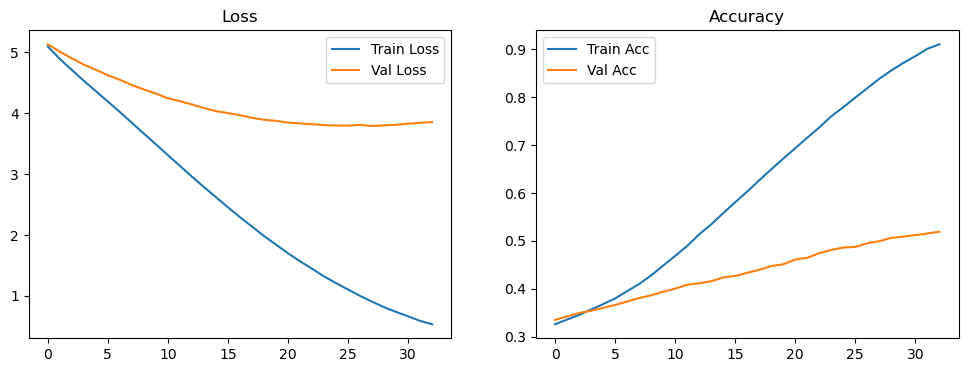

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.show()

In [39]:
#####15 . 문맥을 전혀 이해하지 못해서 파라미터수정###

model = Transformer(
    vocab_size=vocab_size,
    d_model=256,       
    num_heads=8,        
    num_layers=4,       
    d_ff=512,          
    max_seq_length=128,
    dropout=0.5        
)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = optim.Adam(model.parameters(), lr=5e-5) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [40]:
#============16. 재학습 에포크 (50)=============
best_val_loss = float('inf')
patience = 5
patience_counter = 0

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # ========== 훈련 모드 ==========
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        enc_input = batch['encoder_input'].to(device)
        dec_input = batch['decoder_input'].to(device)
        dec_target = batch['decoder_target'].to(device)
        
        output = model(enc_input, dec_input)
        loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # 훈련 정확도 계산
        predictions = output.view(-1, vocab_size).argmax(dim=-1)
        targets = dec_target.view(-1)
        
        # PAD 토큰 제외하고 정확도 계산
        mask = targets != PAD_ID
        train_correct += (predictions == targets)[mask].sum().item()
        train_total += mask.sum().item()
    
    # ========== 검증 모드 ==========
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            enc_input = batch['encoder_input'].to(device)
            dec_input = batch['decoder_input'].to(device)
            dec_target = batch['decoder_target'].to(device)
            
            output = model(enc_input, dec_input)
            loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
            
            total_val_loss += loss.item()
            
            # 검증 정확도 계산
            predictions = output.view(-1, vocab_size).argmax(dim=-1)
            targets = dec_target.view(-1)
            
            # PAD 토큰 제외하고 정확도 계산
            mask = targets != PAD_ID
            val_correct += (predictions == targets)[mask].sum().item()
            val_total += mask.sum().item()
    
    # ========== 평균 계산 ==========
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = train_correct / train_total if train_total > 0 else 0
    val_accuracy = val_correct / val_total if val_total > 0 else 0
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("  ✓ 모델 저장됨")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break
    
    print("-" * 50)

Epoch 1/50:
  Train Loss: 6.6514, Train Acc: 0.2685
  Val Loss: 6.0121, Val Acc: 0.2914
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 2/50:
  Train Loss: 5.9379, Train Acc: 0.2887
  Val Loss: 5.8337, Val Acc: 0.2954
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 3/50:
  Train Loss: 5.8026, Train Acc: 0.2912
  Val Loss: 5.7723, Val Acc: 0.2939
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 4/50:
  Train Loss: 5.7231, Train Acc: 0.2922
  Val Loss: 5.6784, Val Acc: 0.2994
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 5/50:
  Train Loss: 5.6541, Train Acc: 0.2947
  Val Loss: 5.6278, Val Acc: 0.3042
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 6/50:
  Train Loss: 5.5944, Train Acc: 0.2986
  Val Loss: 5.5574, Val Acc: 0.3066
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 7/50:
  Train Loss: 5.5388, Train Acc: 0.3021
  Val Loss: 5.5159, Val Acc: 0.3090
  ✓ 모델 저장됨
-

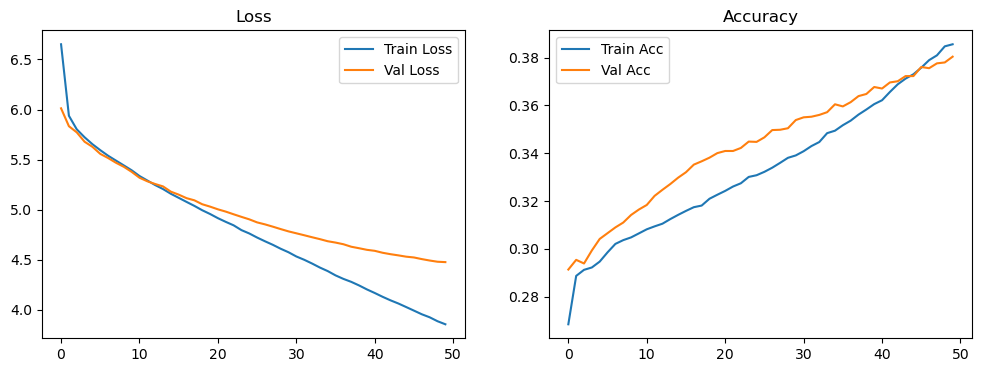

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.show()

In [42]:
# 테스트
test_questions = ["안녕하세요", "오늘 날씨 어때?", "뭐하고 있어?"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 안녕하세요
A: 좋은 만남이었길 바라요.

Q: 오늘 날씨 어때?
A: 직접 물어보세요.

Q: 뭐하고 있어?
A: 사람마다 다르겠지만 사귀고 나서 가도 수 있을 거예요.



In [43]:
# 테스트
test_questions = ["누구야"]
for q in test_questions:
    response = generate_response(model, q)
    print(f"Q: {q}")
    print(f"A: {response}\n")

Q: 누구야
A: 좋은 생각이에요.



In [45]:
#============16. 재학습 에포크 (200)=============
best_val_loss = float('inf')
patience = 5
patience_counter = 0

num_epochs = 200
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # ========== 훈련 모드 ==========
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        enc_input = batch['encoder_input'].to(device)
        dec_input = batch['decoder_input'].to(device)
        dec_target = batch['decoder_target'].to(device)
        
        output = model(enc_input, dec_input)
        loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # 훈련 정확도 계산
        predictions = output.view(-1, vocab_size).argmax(dim=-1)
        targets = dec_target.view(-1)
        
        # PAD 토큰 제외하고 정확도 계산
        mask = targets != PAD_ID
        train_correct += (predictions == targets)[mask].sum().item()
        train_total += mask.sum().item()
    
    # ========== 검증 모드 ==========
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            enc_input = batch['encoder_input'].to(device)
            dec_input = batch['decoder_input'].to(device)
            dec_target = batch['decoder_target'].to(device)
            
            output = model(enc_input, dec_input)
            loss = criterion(output.view(-1, vocab_size), dec_target.view(-1))
            
            total_val_loss += loss.item()
            
            # 검증 정확도 계산
            predictions = output.view(-1, vocab_size).argmax(dim=-1)
            targets = dec_target.view(-1)
            
            # PAD 토큰 제외하고 정확도 계산
            mask = targets != PAD_ID
            val_correct += (predictions == targets)[mask].sum().item()
            val_total += mask.sum().item()
    
    # ========== 평균 계산 ==========
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = train_correct / train_total if train_total > 0 else 0
    val_accuracy = val_correct / val_total if val_total > 0 else 0
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("  ✓ 모델 저장됨")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break
    
    print("-" * 50)

Epoch 1/200:
  Train Loss: 3.8305, Train Acc: 0.3885
  Val Loss: 4.4695, Val Acc: 0.3809
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 2/200:
  Train Loss: 3.7937, Train Acc: 0.3925
  Val Loss: 4.4537, Val Acc: 0.3810
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 3/200:
  Train Loss: 3.7532, Train Acc: 0.3956
  Val Loss: 4.4477, Val Acc: 0.3829
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 4/200:
  Train Loss: 3.7260, Train Acc: 0.3990
  Val Loss: 4.4343, Val Acc: 0.3846
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 5/200:
  Train Loss: 3.6904, Train Acc: 0.4018
  Val Loss: 4.4285, Val Acc: 0.3852
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 6/200:
  Train Loss: 3.6612, Train Acc: 0.4046
  Val Loss: 4.4186, Val Acc: 0.3866
  ✓ 모델 저장됨
--------------------------------------------------
Epoch 7/200:
  Train Loss: 3.6319, Train Acc: 0.4070
  Val Loss: 4.4111, Val Acc: 0.3871
  ✓ 모

KeyboardInterrupt: 

In [44]:
#################회고###############
우선 챗봇을 만들기에는 학습데이터가 적기때문에 파라미터들을 수정해봐도 
과적합이거나 문맥에 맞지않는 답을 하는 경우로 나뉘었던것 같다.

그래도 전체적인 트랜스포머 모델 구조를 이해하는데는 큰 도움이 되었던 것 같다.
이런 저런 수정을 진행해봤지만  모델 성능을 높이는데에는 좀 어려움이 있었다.
